## Configurations for Colab

In [1]:
import os
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    !pip install -U gym
    from pyvirtualdisplay import Display
    
    # strat virtual display
    dis = Display(visible=0,size=(400,400))
    dis.start()

if IN_COLAB and not os.path.exists("segment_tree.py"):
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py

## Prioritized Experience Replay

In [2]:
from typing import Dict,List,Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from segment_tree import MinSegmentTree,SumSegmentTree

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer"""
    
    def __init__(self,obs_dim: int,size: int,batch_size: int=32):
        self.obs_buf = np.zeros([size,obs_dim],dtype=np.float32) # 观测的当前状态大小 X 每一个观测状态reshape后的维度
        self.next_obs_buf = np.zeros([size,obs_dim],dtype=np.float32) # 观测的下一状态大小 X 每一个观测的下一个状态reshape后的维度
        self.acts_buf = np.zeros([size],dtype=np.float32) # 记录状态变迁的过程中具体执行了那个动作
        self.rews_buf = np.zeros([size],dtype=np.float32) # 记录状态变迁过程种具体执行了那个动作后所得到的奖励
        self.done_buf = np.zeros(size,dtype=np.float32) # 记录状态变迁后新的状态是否为结束
        self.max_size = size # 指定ReplayBuffer的大小
        self.batch_size = batch_size # 指定batch_size的大小
        self.ptr = 0 # 指定当前batch数据起始位置在全部数据池中的位置
        self.size = 0 # 暂时记录当前数据量的大小
    
    def store(self,obs:np.ndarray,act:np.ndarray,rew:float,next_obs:np.ndarray,done:bool):
        # 传入参数分别为 当前观测到的状态 当前所选择的动作 执行动作所得到的回馈值 执行动作后得到的下一状态 执行下一动作后episode是否结束
        self.obs_buf[self.ptr] = obs # 观测状态
        self.next_obs_buf[self.ptr] = next_obs # 下一观测状态
        self.acts_buf[self.ptr] = act # 以状态选择的动作
        self.rews_buf[self.ptr] = rew # 累计回馈值
        self.done_buf[self.ptr] = done # 标记每一步是否导致游戏结束
        self.ptr = (self.ptr + 1) % self.max_size # 记录当前最新的数据(s,a,r,s')位置
        self.size = min(self.size + 1,self.max_size) # 记录当前缓冲区中的数据量
    
    def sample_batch(self)->Dict[str,np.ndarray]: # 随即返回一个批次的数据字典
        idxs = np.random.choice(self.size,size = self.batch_size,replace=False) # 为了消除连续性对模型的影响，首先将数据进行混洗操作
        return dict(obs=self.obs_buf[idxs],next_obs=self.next_obs_buf[idxs],acts=self.acts_buf[idxs],rews=self.rews_buf[idxs],done=self.done_buf[idxs]) # 依据采样结果将所有的数据进行切片并按照规则返回
    
    def __len__(self) -> int:
        return self.size # 返回当前数据量的大小

In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay Buffer"""
    """
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
    """
    def __init__(self,obs_dim:int,size:int,batch_size:int=32,alpha:float=0.7):  
        assert alpha >= 0
        super(PrioritizedReplayBuffer,self).__init__(obs_dim=obs_dim,size=size,batch_size=batch_size)
        self.max_priority = 1.0 # 设定最大优先级
        self.tree_ptr = 0 # 设定当前线段树节点在数组中的下标
        self.alpha = alpha # 设定优先级重放缓冲区的参数α
        tree_capacity = 1 # 设定线段树初始容量
        """按照线段树的规则增加其自身的容量"""
        while tree_capacity < self.max_size: # 将线段树的容量定义成2的指数次幂，使之成为满二叉树
            tree_capacity *= 2
        self.sum_tree = SumSegmentTree(tree_capacity) # 定义求区间和用的线段树
        self.min_tree = MinSegmentTree(tree_capacity) # 定义求区间最小值的线段树
    
    def store(self,obs:np.ndarray,act:int,rew:float,next_obs:np.ndarray,done:bool):
        """store experience and priority"""
        super().store(obs=obs,act=act,rew=rew,next_obs=next_obs,done=done) # 将数据存储到缓冲区当中
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha # 在sum_tree中对应位置存储最新transition的优先级
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha # 在min_tree中对应位置存储最新transition的优先级
        self.tree_ptr = (self.tree_ptr + 1) % self.max_size # 将整体的transition数量指针加一
    
    def _calculate_weight(self,idx:int,beta:float): 
        """calculate the weight of the experience at idx"""
        # 这句话对应于伪代码中的第9行 
        p_sample = self.sum_tree[idx]/self.sum_tree.sum() 
        # 下面四句话对应于伪代码中的第十行 
        p_min = self.min_tree.min() / self.sum_tree.sum() # 根据论文中的伪代码(wi=(1/(N*P(i)))^β)为了计算max_weight需要求得p_min
        max_weight = (p_min*len(self))**(-beta) # 计算最大权重 由公式(wi=(1/(N*P(i)))^β)得知，最大权重需要获得p_min,最后进行计算
        weight = (p_sample*len(self))**(-beta) # 计算IS weight 的分子部分
        weight = weight / max_weight
        # 返回刚刚计算所得到的对应于idx号transition的priority权重
        return weight # 按照论文伪代码计算idx号区间 IS weight 的大小
    
    def _sample_proportional(self) -> List[int]:
        """sample indices based on properties"""
        indices = [] # 存储根据计算所得到的具有最佳优先级的transitions所构成的一个batch
        p_total = self.sum_tree.sum(0,len(self)-1) # 计算并得到所有的transition优先级的和
        segment = p_total / self.batch_size # 为了使得数据被均匀采样，用分层抽样的方法按照segment选取transition
        for i in range(self.batch_size):
            a = segment * i # 得到每一个segment最左侧下标
            b = segment * (i+1) # 得到每一个segment最右侧下标
            upperbound = random.uniform(a,b) # 将区间[a,b]内部某一个值作为本次采样的最大值
            idx = self.sum_tree.retrieve(upperbound=upperbound) # 找到这个值的最大下标
            indices.append(idx) # 将这个值最为transition在数据池中的下标记录并返回
        return indices # 得到一个batch_size的每一个transition在数据池中的下标(也就是他们优先级列表对应的优先级数值的下标)
    
    def sample_batch(self,beta:float=0.5) -> Dict[str,np.ndarray]: # 按照此前计算的优先级计算并找出合适的batch
        """sample a batch of experience"""
        assert len(self) >= self.batch_size # 检查当前数据量是否大于batch_size
        assert beta > 0 # 检查β参数是否大于零
        indices = self._sample_proportional() # 根据分层采样规则获取本次批次数据的各个transition的下标
        obs = self.obs_buf[indices] # 依照下标选择 当前状态
        next_obs = self.next_obs_buf[indices] # 依照下标选择 下一状态
        acts = self.acts_buf[indices] # 依照下标选择 过渡动作
        rews = self.rews_buf[indices] # 依照下标选择 收益值
        done = self.done_buf[indices] # 依照下标选择 结束标志
        weights = np.array([self._calculate_weight(i,beta) for i in indices]) # 计算每一个transition的优先级权重Ωi
        return dict(obs=obs,next_obs=next_obs,acts=acts,rews=rews,done=done,weights=weights,indices=indices) # 返回成批的数据
    
    def update_priorities(self,indices:List[int],priorities:np.ndarray): # 更新采样数据的优先级
        """Update priorities of sampled transitions"""
        assert len(indices) == len(priorities)
        for idx,priority in zip(indices,priorities): # 对于刚刚选取的每一个transition
            assert priority > 0 # 检查优先级的合法性
            assert 0 <= idx < len(self) # 检查下标的合法性
            self.sum_tree[idx] = priority ** self.alpha # 更新优先级
            self.min_tree[idx] = priority ** self.alpha # 更新优先级
            self.max_priority = max(self.max_priority,priority) # 更新并存储最大优先级         

In [5]:
class Network(nn.Module):
    
    def __init__(self,in_dim:int,out_dim:int):
        super(Network,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=in_dim,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=out_dim)
        )
    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.layers(x)

### Information of DQN Agent

| Method                | Note                                                                     |
| ---                   | ---                                                                      |
|select_action          | select an action from the input state.                                   |
|step                   | take an action and return the response of the env.                       |
|compute_dqn_loss       | return dqn loss.                                                         |
|update_model           | update the model by gradient descent.                                    |
|target_hard_update     | hard update from the local model to the target model.                    |
|train                  | train the agent during num_frames.                                       |
|test                   | test the agent (1 episode).                                              |
|plot                   | plot the training progresses.                                            |
|=======================|==========================================================================|
| Attribute             | Note                                                                     |
|env (gym.Env)          | openAI Gym environment                                                   |
|memory (ReplayBuffer)  | replay memory to store transitions                                       |
|batch_size (int)       | batch size for sampling                                                  |
|epsilon (float)        | parameter for epsilon greedy policy                                      |
|epsilon_decay (float)  | step size to decrease epsilon                                            |
|max_epsilon (float)    | max value of epsilon                                                     |
|min_epsilon (float)    | min value of epsilon                                                     |
|target_update (int)    | period for target model's hard update                                    |
|gamma (float)          | discount factor                                                          |
|dqn (Network)          | model to train and select actions                                        |
|dqn_target (Network)   | target model to update                                                   |
|optimizer (torch.optim)| optimizer for training dqn                                               |
|transition (list)      | transition information including  state, action, reward, next_state, done|
|beta (float)           | determines how much importance sampling is used                          |
|prior_eps (float)      | gurantees every transition can be sampled                                |

In [6]:
class DQNAgent:
    
    def __init__(self,env:gym.Env,memory_size:int,batch_size:int,target_update:int,epsilon_decay:float,max_epsilon:float=1.0,min_epsilon:float=0.1,gamma:float=0.99,alpha:float=0.2,beta:float=0.6,prior_eps:float=1e-6):
        obs_dim = env.observation_space.shape[0] # 得到状态空间的大小
        action_dim = env.action_space.n # 得到动作空间的大小
        
        self.env = env # 自定义环境
        self.batch_size = batch_size # 设置batch_size的大小
        self.epsilon = max_epsilon # 设定ε-greedy算法中的ε参数
        self.epsilon_decay = epsilon_decay # 环境递减探索比例因子
        self.max_epsilon = max_epsilon # ε变化上限
        self.min_epsilon = min_epsilon # ε变化下限
        self.target_update = target_update # 主干网络 次要网络参数同步周期
        self.gamma = gamma # 折扣因子
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 定义模型训练位置
        self.beta = beta # 设定参数β
        self.prior_eps = prior_eps # 设定prior变化率
        self.memory = PrioritizedReplayBuffer(obs_dim=obs_dim,size=memory_size,batch_size=batch_size,alpha=alpha) # 定义具有优先级的数据缓冲池
        self.dqn = Network(in_dim=obs_dim,out_dim=action_dim).to(self.device) # 自定义主干DQN网络
        self.dqn_target = Network(in_dim=obs_dim,out_dim=action_dim).to(self.device) # 自定义非主干DQN网络
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主干网络与次要网络参数 这两个网络是在后面同时使用的
        self.dqn_target.eval() # 将次要网络设置成贪婪模式
        self.optimizer = optim.Adam(self.dqn.parameters()) # 定义优化器
        self.transition = list() # 临时存储状态动作对的地方
        self.is_test = False # Flag用于决定当前是否为测试状态
    
    def select_action(self,state:np.ndarray) -> np.ndarray:
        """基于ε-greedy算法依据当前的状态选择最佳动作"""
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample() # 探索:随机选择一个动作
        else:
            selected_action = self.dqn(torch.FloatTensor(state).to(self.device)).argmax() # 利用:根据当前状态选择最佳动作
            selected_action = selected_action.detach().cpu().numpy() # 将返回会选择的最佳动作转换成numpy格式
        if not self.is_test: # 如果不是在测试状态下
            self.transition = [state,selected_action] # 构建一个新的状态动作对
        return selected_action
    
    def step(self,action:np.ndarray)->Tuple[np.ndarray,np.float64,bool]:
        """take an action and reeturn the response of the env"""
        next_state,reward,done,_ = self.env.step(action=action)
        if not self.is_test: # 如果不是在测试状态下，那么要将当前的实验结果加入到数据池当中
            self.transition += [reward,next_state,done] # 注意这里是+=符号 ，这会使得最终的self.transition=[state,selected_action,reward,next_state,done]     
            self.memory.store(*self.transition) # 将一笔经验打散并存入经验池ReplayBuffer当中
        return next_state,reward,done # 每一步执行后，返回下一个状态 回馈值 结束标志
    
    def _compute_dqn_loss(self,samples:Dict[str,np.ndarray]) -> torch.Tensor:
        """返回DQN算法的损失"""
        state = torch.FloatTensor(samples["obs"]).to(self.device) # 大小为 batch_size X in_dim
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device) # 大小为 batch_size X in_dim
        action = torch.LongTensor(samples["acts"].reshape(-1,1)).to(self.device) # 构造一个关于动作的列向量 大小为 batch_size x 1
        reward = torch.FloatTensor(samples["rews"].reshape(-1,1)).to(self.device) # 构造一个关于回馈值的向量 大小为 batch_size x 1
        done = torch.FloatTensor(samples["done"].reshape(-1,1)).to(self.device) # 构造一个关于完成标记的向量 大小为 batch_size x 1
        """
        method to compute Q-value :
            Q(curr_state<not final>) = r + γ*Q(next_state)
            Q(final_state) = r
        """
        curr_q_value = self.dqn(state).gather(1,action) # 这里筛选出当前状态下真正执行的动作的Q值
        # next_q_value = self.dqn_target(next_state).max(dim=1,keepdim=True)[0].detach()
        next_q_value = self.dqn_target(next_state).gather(1,self.dqn(next_state).argmax(dim=1,keepdim=True)).detach()   
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device) # 按照Q-learning函数的更新公式来确定神经网络的预测目标
        elementwised_loss = F.smooth_l1_loss(curr_q_value,target,reduction="none") # 注意这里的损失最终不进行加和，返回值是一个张量
        return elementwised_loss
    
    def update_model(self) -> torch.Tensor:
        """利用梯度下降算法更新模型"""
        samples = self.memory.sample_batch(self.beta) # 按照规则对数据进行采样并得到一个批次的数据
        weights = torch.FloatTensor(samples["weights"].reshape(-1,1)).to(self.device) # 取得权重参数ω
        indices = samples["indices"] # 将上述按规则取出的数据在数据池中的下标取出
        """按元素计算损失"""
        elementwised_loss = self._compute_dqn_loss(samples=samples)
        loss = torch.mean(elementwised_loss * weights) # 将损失乘以权重计算总损失
        self.optimizer.zero_grad() # 清楚上一轮的梯度信息
        loss.backward() # 进行神经网络的反向传播
        self.optimizer.step() # 利用反向传播的结果更新神经网络的各个参数
        """更新数据的优先级"""
        loss_for_prior = elementwised_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices=indices,priorities=new_priorities)
        
        return loss.item() # 返回此次训练的损失
    
    def _target_hard_update(self):
        """ hard update: from local to target Q network """
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主次网络的参数
        
    def _plot(self,frame_idx:int,scores:List[float],losses:List[float],epsilons:List[float]):
        """plot the training progresses"""
        clear_output(wait=True)
        plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三维图像
        
        plt.subplot(131)
        plt.title("frame %s ,score %s"%(frame_idx,np.mean(scores[-10:]))) # 绘制每一个episode的得分
        plt.plot(scores)
        
        plt.subplot(132)
        plt.title("loss") # 绘制每一轮训练的损失
        plt.plot(losses)
        
        plt.subplot(133)
        plt.title("epsilon") # 绘制每一轮训练epsilon的变化
        plt.plot(epsilons)
        
        plt.show() # 显示图像
    
    def train(self,num_frames:int,plotting_interval:int=200):
        """训练智能体，并根据训练结果每200个时间片按序绘制一次图像中的一部分"""
        self.is_test = False
        # 初始化 状态 损失等中间变量
        state,update_cnt,epsilons,losses,scores,score = self.env.reset(),0,[],[],[],0
        for frame_idx in range(1,num_frames + 1):
            """累计训练num_frames个episodes"""
            action = self.select_action(state) # 选择待执行的动作
            next_state,reward,done = self.step(action) # 执行所选择的动作
            state = next_state # 更新状态
            score += reward # 累计当前episodes下的收益
            fraction = min(frame_idx / num_frames,1.0) # 修改beta
            self.beta = self.beta + fraction*(1.0-self.beta)
            
            if done: # 如果到最终状态
                state = self.env.reset() # 重置游戏的状态
                scores.append(score) # 记录下这一轮训练下来的总分数
                score = 0 # 重置游戏的临时分数
            
            # 检查缓冲区是否有足够的可用于训练的数据并依据此判断是否进行训练并执行
            if len(self.memory) >= self.batch_size:
                loss = self.update_model() # 自动进行模型的训练以及参数的更新
                losses.append(loss) # 临时记录训练过程中的损失函数的变化
                update_cnt += 1 # 记录update_cnt，当他到达一定值的时候就同步两个网络
                self.epsilon = max(self.min_epsilon,self.epsilon-(self.max_epsilon-self.min_epsilon)*self.epsilon_decay)
                epsilons.append(self.epsilon) # 记录训练过程中epsilon的变化情况
                # 如果训练次数达到指定的参数同步阈值那么就将两个网络的参数进行同步
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            
            # 依照上述训练结果绘制图像
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx,scores,losses,epsilons)
        self.scores = scores
        self.losses = losses
        self.env.close() # 训练完成后关闭倒立摆环境句柄
    
    def test(self,video_folder:str) -> None:
        """Test the agent"""
        self.is_test = True
        # define 2 object for naive env and video-recordable env respectively
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env,video_folder=video_folder) # 定义视频对象并指定训练视频存放的位置
        
        state = self.env.reset() # 重置代理人环境
        done = False # 假设最初时刻倒立摆并没有倒下
        score = 0 # 记录倒立摆在一个episode下的得分
        i = 0
        while not done :
            i += 1
            import time
            time.sleep(0.02)
            action = self.select_action(state) # 根据当前状态选择一个动作
            next_state,reward,done = self.step(action) # 执行上面所选择的动作然后获得环境的反馈
            state = next_state # 更新智能体的状态
            score += reward # 累计在一个episode过程中的奖励
        self.env.close() # 当一个episode结束之后，释放句柄
        self.env = naive_env
        print("倒立摆一共维持{}步。".format(i))

## Environment Configurations

In [7]:
# setting environment
env_id = "CartPole-v1" # 配制环境id 默认最大步数为500
env = gym.make(env_id) # 初始化环境

# setting random seed
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
# 用于加速
np.random.seed(seed)
seed_torch(seed)
res = env.seed(seed)

## Environment Initialize

In [8]:
# initialize parameters that proccess of trainig needs
num_frames = 30000 # 训练一直执行直到300episodes
memory_size = 200 # 设定记忆串列的大小
batch_size = 32 # 设定每一批次的数据大小为256
target_update = 100# 模型参数同步频率
epsilon_decay = 1/2000 # 探索与利用权衡因子
# define a agent used to training the model defined above
agent = DQNAgent(env=env,memory_size=memory_size,batch_size=batch_size,target_update=target_update,epsilon_decay=epsilon_decay)                   

## Train

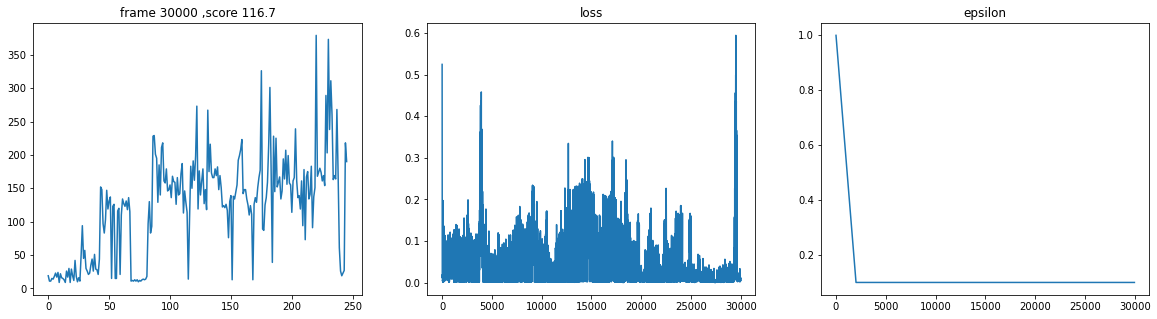

In [9]:
agent.train(num_frames=num_frames)

## Test

In [10]:
# run the trained agent in 1 episode
video_folder = "videos/Prioritized Experience Replay" # 指定测试结果采样帧的存储位置
agent.test(video_folder=video_folder) # 测试DOUBLE-DQN模型 输出当前模型的效果

D:\Anaconda3\envs\pytorch\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at C:\Users\20613\Desktop\14.Rainbow is all you need master\videos\Prioritized Experience Replay folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


倒立摆一共维持481步。


## Render

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/Prioritized Experience Replay\rl-video-episode-0.mp4


## Calculate running average and plot

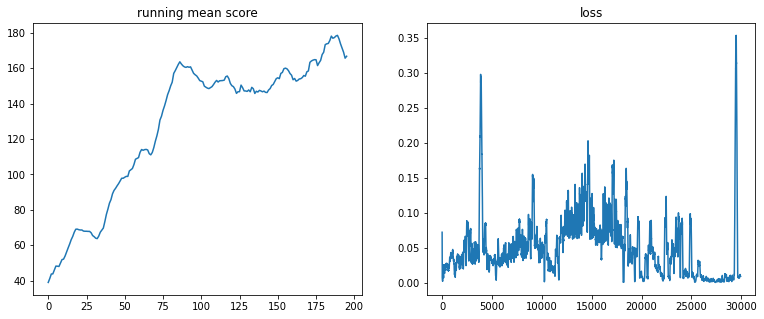

In [12]:
def running_mean(x,N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel@x[i:i+N]
        y[i]/=N
    return y

score = running_mean(np.array(agent.scores)) # 得到分数
loss = running_mean(np.array(agent.losses))  # 得到损失

clear_output(wait=True)
plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三张图像
plt.subplot(131)
plt.title("running mean score") 
plt.plot(score)
plt.subplot(132)
plt.title("loss")
plt.plot(loss)
plt.show() # 显示图像